# Import and loads

In [1]:
import os 
import sys 
import itertools as itt
from pathlib import Path 

import pandas  as pd 
import numpy as np
from dotmap import DotMap

import scipy.stats

from snakemake.io import glob_wildcards


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Data Load

In [3]:
DATA = DotMap()

## miRNA datasets

In [4]:
path = "../data/E14_ivvivt_DEA-miRNA-merged-logFC_clusters.tsv"
df = pd.read_csv(path, sep="\t", header=0, index_col=0)
DATA['input']['mirnas']['ivv_ivt_clustered'] = df

path = "../data/E14_ivvivt_concordant_upregulated_miRNAs.tsv"
df = pd.read_csv(path, sep="\t", header=0, index_col=0)
DATA['input']['mirnas']['candidate_mirnas'] = df

In [5]:
DATA['input']['mirnas']['candidate_mirnas'].sort_values(by='avg_logfc', ascending=False)

,diapaused_ICM,mTor_ICM,paused_E14,cluster,avg_logfc
mmu-miR-1839-5p,2.026016,1.597830,1.632651,1,1.752165
mmu-miR-205-5p,0.573463,3.850874,0.735487,8,1.719941
mmu-miR-26b-5p,0.563257,1.456949,3.082136,1,1.700781
mmu-miR-23a-3p,1.313056,2.979007,0.551531,8,1.614531
mmu-miR-27b-3p,1.186236,2.908505,0.708692,8,1.601144
mmu-miR-676-3p,2.497754,1.419433,0.712663,1,1.543284
mmu-miR-200b-5p,1.862138,0.391647,2.120523,1,1.458103
mmu-miR-200b-3p,1.231986,1.415203,1.423348,1,1.356846
mmu-miR-200c-3p,1.187016,0.978491,1.868178,1,1.344562
mmu-miR-30b-5p,1.407258,2.204026,0.406119,8,1.339134


## promoter datasets

In [6]:
data_promoters = DotMap()

In [7]:

ufmt_logfc_bed = (
    Path("../results") /
    "02_logfc" /
    "u{UP_SIZE}_d{DOWN_SIZE}" /
    "score_{SCORE_TYPE}_{PROCESS_STEP}" / 
    "promoters.bed"
)

wildcards = glob_wildcards(ufmt_logfc_bed)

for upsize, downsize, score_type, process_step in zip(wildcards.UP_SIZE, wildcards.DOWN_SIZE, wildcards.SCORE_TYPE, wildcards.PROCESS_STEP):
    fmt_logfc_bed = str(ufmt_logfc_bed).format(
        UP_SIZE=upsize,
        DOWN_SIZE=downsize,
        SCORE_TYPE=score_type,
        PROCESS_STEP=process_step
    )
    bed = pd.read_csv(
        fmt_logfc_bed,
        header=None,
        index_col=None,
        sep="\t",
        names=['chrom','start','end','name','score','strand']
    )
    data_promoters[f"u{upsize}_d{downsize}"][f"score_{score_type}_{process_step}"] = bed

In [8]:
data_promoters_prior_logfc = DotMap()


ufmt_score_bed = (
    Path("../results") /
    "01_score_promoters" /
    "u{UP_SIZE}_d{DOWN_SIZE}" /
    "score_{SCORE_TYPE}_{PROCESS_STEP}" / 
    "{DAY}.promoters.bed"
)

wildcards = glob_wildcards(ufmt_logfc_bed)

for upsize, downsize, score_type, process_step in zip(wildcards.UP_SIZE, wildcards.DOWN_SIZE, wildcards.SCORE_TYPE, wildcards.PROCESS_STEP):

    for DAY in ['D0','D6']:

        fmt_score_bed = str(ufmt_score_bed).format(
            UP_SIZE=upsize,
            DOWN_SIZE=downsize,
            SCORE_TYPE=score_type,
            PROCESS_STEP=process_step,
            DAY=DAY,
        )
        bed = pd.read_csv(
            fmt_score_bed,
            header=None,
            index_col=None,
            sep="\t",
            names=['chrom','start','end','name','score','strand']
        )
        data_promoters_prior_logfc[f"u{upsize}_d{downsize}"][f"score_{score_type}_{process_step}"][DAY] = bed

In [9]:
print(data_promoters['u500_d100']['score_mean_robustMaxScaled'].head(3))
print(data_promoters['u500_d100']['score_mean_robustMaxScaled'].shape)

print(data_promoters_prior_logfc['u500_d100']['score_mean_robustMaxScaled']['D0'].head(3))
print(data_promoters_prior_logfc['u500_d100']['score_mean_robustMaxScaled']['D0'].shape)

  chrom     start       end                             name     score strand
0  chr1  20681448  20682049  mmu-miR-133b-3p,mmu-miR-133b-5p  0.000000      +
1  chr1  34011092  34011693  mmu-miR-6896-3p,mmu-miR-6896-5p  0.079409      +
2  chr1  34433186  34433787                     mmu-miR-5103  0.134248      -
(641, 6)
  chrom     start       end                             name     score strand
0  chr1  20681448  20682049  mmu-miR-133b-3p,mmu-miR-133b-5p  0.000000      +
1  chr1  34011092  34011693  mmu-miR-6896-3p,mmu-miR-6896-5p  0.259777      +
2  chr1  34433186  34433787                     mmu-miR-5103  0.035193      -
(641, 6)


# Explore

## List miRNAs

In [11]:
DATA.input.mirnas['candidate_mirnas'].head(3)

,diapaused_ICM,mTor_ICM,paused_E14,cluster,avg_logfc
mmu-miR-1839-5p,2.026016,1.597830,1.632651,1,1.752165
mmu-miR-205-5p,0.573463,3.850874,0.735487,8,1.719941
mmu-miR-26b-5p,0.563257,1.456949,3.082136,1,1.700781


In [12]:
mirna_dea = DATA.input.mirnas['ivv_ivt_clustered'].copy()

list_mirna_ivv_ivt_up = mirna_dea.loc[
    (mirna_dea.apply(lambda row: (row>0).all(), axis=1)) &
    (mirna_dea['cluster'].isin([1,8])),
    :].index.values

assert set(list_mirna_ivv_ivt_up) == set(DATA.input.mirnas['candidate_mirnas'].index.values)

list_mirna_ivv_ivt_other = mirna_dea.loc[~(mirna_dea.apply(lambda row: (row>0).all(), axis=1)),:].index.values

In [13]:
print(len(list_mirna_ivv_ivt_up))
print(len(list_mirna_ivv_ivt_other))

24
284


In [14]:
for mirna in list_mirna_ivv_ivt_up:
    print(f'"{mirna}",')

"mmu-let-7d-5p",
"mmu-let-7g-5p",
"mmu-miR-141-3p",
"mmu-miR-148a-3p",
"mmu-miR-1839-5p",
"mmu-miR-200a-3p",
"mmu-miR-200b-3p",
"mmu-miR-200b-5p",
"mmu-miR-200c-3p",
"mmu-miR-205-5p",
"mmu-miR-224-5p",
"mmu-miR-23a-3p",
"mmu-miR-26b-5p",
"mmu-miR-27b-3p",
"mmu-miR-30b-5p",
"mmu-miR-30d-5p",
"mmu-miR-322-5p",
"mmu-miR-429-3p",
"mmu-miR-434-3p",
"mmu-miR-503-3p",
"mmu-miR-532-3p",
"mmu-miR-574-5p",
"mmu-miR-676-3p",
"mmu-miR-98-5p",


## Numbers : ivv ivt vs ivt ; measured miRNAs vs all miRNAs

In [15]:
path = "../results/00_preprocess_promoters/00_onebase/promoters.bed"
tmp_bed = pd.read_csv(path, header=None, index_col=None, sep="\t", names=['chrom','start','end','name','score','strand'])

In [16]:
tmp_bed['is_candidate'] = (tmp_bed['name'].replace(np.nan,'').str.split(',').map(set).apply(
    lambda v: len(v & set(list_mirna_ivv_ivt_up))
    )>0
).values

tmp_bed['is_background'] = (tmp_bed['name'].replace(np.nan,'').str.split(',').map(set).apply(
    lambda v: len(v & set(list_mirna_ivv_ivt_other))
    )>0
).values

print("NUMBER OF PROMOTERS: measured miRNAS candidates vs measured other miRNAs")

print("promoters of measured candidate miRNAs", tmp_bed['is_candidate'].sum())
print("promoters of measured non-candidate miRNAs", tmp_bed['is_background'].sum())
print("Total number of promoters", tmp_bed.shape[0])

NUMBER OF PROMOTERS: measured miRNAS candidates vs measured other miRNAs
promoters of measured candidate miRNAs 14
promoters of measured non-candidate miRNAs 95
Total number of promoters 641


In [17]:
# ALTERNATIVE : CONSIDERING THE UP status only in IVT 
# 2023-09-17 : I think this is wrong because we only consider the subset of miRNAs which are in common with ivv.
# There are more miRNAs ivt which are up.

list_mirna_ivt_up = mirna_dea.loc[lambda df: df['paused_E14']>0,:].index.values
list_mirna_ivt_other = mirna_dea.loc[lambda df: df['paused_E14']<=0,:].index.values

tmp_bed['is_candidate'] = (tmp_bed['name'].replace(np.nan,'').str.split(',').map(set).apply(
    lambda v: len(v & set(list_mirna_ivt_up))
    )>0
).values

tmp_bed['is_background'] = (tmp_bed['name'].replace(np.nan,'').str.split(',').map(set).apply(
    lambda v: len(v & set(list_mirna_ivt_other))
    )>0
).values


print("NUMBER OF PROMOTERS: measured miRNAS candidates vs measured other miRNAs")

print("promoters of measured candidate miRNAs", tmp_bed['is_candidate'].sum())
print("promoters of measured non-candidate miRNAs", tmp_bed['is_background'].sum())
print("Total number of promoters", tmp_bed.shape[0])
print(tmp_bed['is_candidate'].sum())
print(tmp_bed['is_background'].sum())
print(tmp_bed.shape[0])

NUMBER OF PROMOTERS: measured miRNAS candidates vs measured other miRNAs
promoters of measured candidate miRNAs 69
promoters of measured non-candidate miRNAs 59
Total number of promoters 641
69
59
641


## Example Tests and viz

### Preprocess

In [18]:
def promoter_set_id_to_string(promoterset_id: str) -> str:
    up, down = promoterset_id.split("_")
    up = up.replace("u","")
    down = down.replace("d","")
    up = int(up)
    down = int(down)
    descr = f"upstream = {up:,}nt, downstream = {down:,}nt"
    return descr

In [19]:
selected_promoterset = "u1500_d500"
selected_scoring_method = "score_max_robustMaxScaled"

example_df = data_promoters[selected_promoterset][selected_scoring_method].copy()
example_df['is_candidate'] = (
    example_df['name'].replace(np.nan,'').str.split(',').map(set).apply(
        lambda v: len(v & set(list_mirna_ivv_ivt_up))
    )>0
).values


example_df['is_background'] = (
    example_df['name'].replace(np.nan,'').str.split(',').map(set).apply(
        lambda v: len(v & set(list_mirna_ivv_ivt_other))
    )>0
).values


# 2023-09-18 - now considering only the subset of promoters associated to ivv-ivt miRNAs
example_df['is_set_selected_mirnas'] = (example_df['is_candidate'].astype(bool)).values


df = example_df.loc[lambda df: ( (df['is_background']) | (df['is_candidate'])) ,:].dropna().copy()


In [20]:
df.sort_values(by='score').head(3)

,chrom,start,end,name,score,strand,is_candidate,is_background,is_set_selected_mirnas
164,chr13,21934977,21936978,mmu-miR-1983,-0.497481,-,False,True,False
241,chr15,103271398,103273399,"mmu-miR-148b-3p,mmu-miR-148b-5p",-0.429059,+,False,True,False
522,chr7,45128235,45130236,mmu-miR-5121,-0.428563,-,False,True,False


In [21]:
pd.concat([
    data_promoters_prior_logfc[selected_promoterset][selected_scoring_method]['D0'].iloc[[150],:].assign(condition='WT'),
    data_promoters_prior_logfc[selected_promoterset][selected_scoring_method]['D6'].iloc[[150],:].assign(condition='paused')
], axis=0)

,chrom,start,end,name,score,strand,condition
150,chr12,109716893,109718894,"mmu-miR-495-3p,mmu-miR-495-5p,mmu-miR-667-3p,m...",0.093596,+,WT
150,chr12,109716893,109718894,"mmu-miR-495-3p,mmu-miR-495-5p,mmu-miR-667-3p,m...",0.000000,+,paused


### Test and viz

In [22]:
mwu_example = scipy.stats.mannwhitneyu(
    #df.loc[lambda d: d['is_set_selected_mirnas'],:].loc[lambda df: df['score'].abs()<5,'score'],
    #df.loc[lambda d: ~d['is_set_selected_mirnas'],:].loc[lambda df: df['score'].abs()<5,'score'],
    df.loc[lambda d: d['is_set_selected_mirnas'],'score'],
    df.loc[lambda d: ~d['is_set_selected_mirnas'],'score'],
    alternative="greater",
)
print(mwu_example)

MannwhitneyuResult(statistic=831.0, pvalue=0.018493739068814397)


In [23]:
df.loc[df['is_set_selected_mirnas'],:].sort_values(by='score',ascending=False)

,chrom,start,end,name,score,strand,is_candidate,is_background,is_set_selected_mirnas
174,chr13,63238571,63240572,"mmu-miR-23b-3p,mmu-miR-23b-5p,mmu-miR-24-1-5p,...",0.367631,+,True,True,True
627,chrX,99974132,99976133,"mmu-miR-676-3p,mmu-miR-676-5p",0.176490,+,True,False,True
452,chr5,64968613,64970614,"mmu-miR-574-3p,mmu-miR-574-5p",0.129955,+,True,False,True
35,chr1,193509709,193511710,"mmu-miR-205-3p,mmu-miR-205-5p",0.091877,-,True,False,True
618,chrX,72274250,72276251,"mmu-miR-224-3p,mmu-miR-224-5p,mmu-miR-452-3p,m...",0.069865,-,True,False,True
440,chr4,156059316,156061317,"mmu-miR-200a-3p,mmu-miR-200a-5p,mmu-miR-200b-3...",0.062275,-,True,True,True
167,chr13,48536444,48538445,"mmu-let-7d-3p,mmu-let-7d-5p",0.054448,-,True,True,True
213,chr15,68362653,68364654,"mmu-miR-30d-3p,mmu-miR-30d-5p",0.028459,-,True,False,True
639,chrX,151801821,151803822,"mmu-let-7f-2-3p,mmu-let-7f-5p,mmu-miR-3113-3p,...",0.009289,+,True,True,True
7,chr1,74390173,74392174,"mmu-miR-26b-3p,mmu-miR-26b-5p",-0.029275,+,True,False,True


#### Plot

In [24]:
print(selected_scoring_method)

score_max_robustMaxScaled


In [64]:
(
    df.loc[lambda d: d['is_set_selected_mirnas'],:]
        .sort_values(by='score', ascending=False)
        .assign(subset_candidate_name = lambda d: d['name'].apply(lambda v: ','.join([m for m in v.split(',') if m in list_mirna_ivv_ivt_up])))
)

,chrom,start,end,name,score,strand,is_candidate,is_background,is_set_selected_mirnas,subset_candidate_name
174,chr13,63238571,63240572,"mmu-miR-23b-3p,mmu-miR-23b-5p,mmu-miR-24-1-5p,...",0.367631,+,True,True,True,mmu-miR-27b-3p
627,chrX,99974132,99976133,"mmu-miR-676-3p,mmu-miR-676-5p",0.176490,+,True,False,True,mmu-miR-676-3p
452,chr5,64968613,64970614,"mmu-miR-574-3p,mmu-miR-574-5p",0.129955,+,True,False,True,mmu-miR-574-5p
35,chr1,193509709,193511710,"mmu-miR-205-3p,mmu-miR-205-5p",0.091877,-,True,False,True,mmu-miR-205-5p
618,chrX,72274250,72276251,"mmu-miR-224-3p,mmu-miR-224-5p,mmu-miR-452-3p,m...",0.069865,-,True,False,True,mmu-miR-224-5p
440,chr4,156059316,156061317,"mmu-miR-200a-3p,mmu-miR-200a-5p,mmu-miR-200b-3...",0.062275,-,True,True,True,"mmu-miR-200a-3p,mmu-miR-200b-3p,mmu-miR-200b-5..."
167,chr13,48536444,48538445,"mmu-let-7d-3p,mmu-let-7d-5p",0.054448,-,True,True,True,mmu-let-7d-5p
213,chr15,68362653,68364654,"mmu-miR-30d-3p,mmu-miR-30d-5p",0.028459,-,True,False,True,mmu-miR-30d-5p
639,chrX,151801821,151803822,"mmu-let-7f-2-3p,mmu-let-7f-5p,mmu-miR-3113-3p,...",0.009289,+,True,True,True,mmu-miR-98-5p
7,chr1,74390173,74392174,"mmu-miR-26b-3p,mmu-miR-26b-5p",-0.029275,+,True,False,True,mmu-miR-26b-5p


./u1500_d500_score_max_robustMaxScaled_tfe3_signal_boxplot.with_points.svg


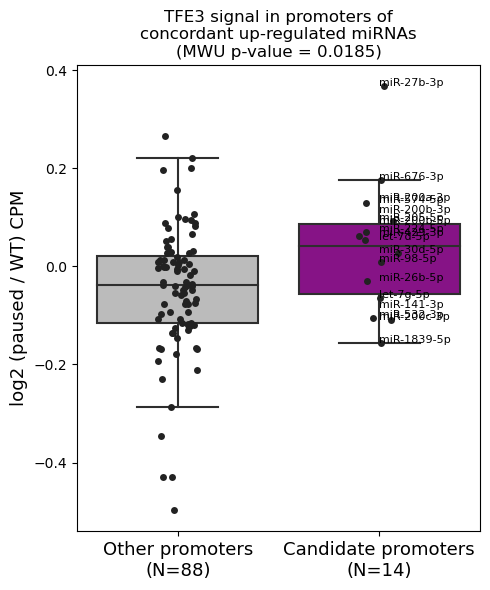

In [58]:

SAVEFIG = True
WITH_POINTS = True
WITH_LABELS = True # NOTE: no sense to have this to True while "WITH_POINTS" is False

fig = plt.figure(figsize=(5,6))
ax1 = fig.add_subplot(1,1,1)

sns.boxplot(
    data=df,
    x='is_set_selected_mirnas',
    y='score',
    palette={True:'#990099', False:'#BBBBBB'},
    showfliers=False,
    ax=ax1,
)

if WITH_POINTS:
    sns.stripplot(
        #data=df.loc[lambda df: df['score'].abs()<5,:],
        data=df,
        x='is_set_selected_mirnas',
        y='score',
        #palette={True:'#990099', False:'#BBBBBB'},
        color='#222222',
        ax=ax1,
    )

if WITH_LABELS and WITH_POINTS:
    # Get the positions of the points 
    # label the points from the candidate promoter set

    xtick_loc = {v.get_text(): v.get_position()[0] for v in ax1.get_xticklabels()}
    x_pos = list(xtick_loc.items())[1][1]

    for i, row in df.loc[lambda df: df['is_set_selected_mirnas'],:].iterrows():
        ax1.annotate(
            xy=(x_pos, row['score']),
            text="\n".join([mirna.split('mmu-')[1] for mirna in row['name'].split(',') if mirna in list_mirna_ivv_ivt_up]),
            fontsize=8,
        )



rename_ticklabels = {
    str(True):f"Candidate promoters\n(N={df['is_set_selected_mirnas'].sum():,})",
    str(False):f"Other promoters\n(N={(~df['is_set_selected_mirnas']).sum()})",
}
ax1.set_xticklabels(
    [
        rename_ticklabels[tick_label.get_text()]
        for tick_label in ax1.get_xticklabels()
    ],
    fontsize=13,
)
ax1.set_xlabel("")

ax1.set_ylabel("log2 (paused / WT) CPM", fontsize=13)

title = (
    f"TFE3 signal in promoters of\n" 
    "concordant up-regulated miRNAs\n"
    f"(MWU p-value = {mwu_example.pvalue:.3})"
)
ax1.set_title(title)

plt.tight_layout()

SAVEFIG_FILE = f"./{selected_promoterset}_{selected_scoring_method}_tfe3_signal_boxplot.{['no_points', 'with_points'][WITH_POINTS]}.{['no_labels', 'with_labels'][WITH_LABELS]}.svg"
if SAVEFIG:
    print(SAVEFIG_FILE)
    plt.savefig(SAVEFIG_FILE)

plt.show()

#### Export table

In [24]:
EXPORT = False
if EXPORT:
    fp = f"./{selected_promoterset}_{selected_scoring_method}_tfe3_signal_measured_promoters.tsv"
    print(fp)
    df.to_csv(
        fp,
        header=True,
        index=False,
        sep="\t"
    )

# Full computation

## Compute

Dimensions : 

- promoter coordinates
- score type and preprocessing
- list miRNAs (positive, background)
- test : MWU vs t-test




In [33]:
data_full_tests_proms = DotMap()

In [77]:
data_full_tests = []

for promoter_coords in data_promoters.keys():
    
    for score_processing in data_promoters[promoter_coords].keys():
        
        print(promoter_coords, score_processing)

        full_bed_scores = data_promoters[promoter_coords][score_processing]
        if not isinstance(full_bed_scores, pd.DataFrame):
            continue
        

        # candidate = ivv ivt
        # bg = all

        # mirna_set = "cand_IvvIvtUp_vs_all"
        # ==================================
        
        bed_scores = full_bed_scores.copy()
        mirna_set = "cand_IvvIvtUp_vs_all"

        bed_scores['is_candidate'] = (bed_scores['name'].replace(np.nan,'').str.split(',').map(set).apply(
            lambda v: len(v & set(list_mirna_ivv_ivt_up))
            )>0
        ).values

        bed_scores['is_background'] = (~bed_scores['is_candidate']).values

        data_full_tests_proms[promoter_coords][score_processing][mirna_set] = bed_scores

        A = bed_scores.loc[lambda df: df['is_candidate'], 'score'].dropna().values
        B = bed_scores.loc[lambda df: df['is_background'], 'score'].dropna().values



        for test_name, test_fun in zip(['MWU','TTEST'], [scipy.stats.mannwhitneyu, scipy.stats.ttest_ind]):
            statistic, p_value = test_fun(A, B, alternative='greater')
            r = pd.Series(
                [promoter_coords,score_processing,mirna_set,test_name,statistic,p_value],
                index=['prom_coords','score_processing','mirna_set','test','stat','pval']
            )
            data_full_tests.append(r)

        # mirna_set = "cand_IvvIvtUp_vs_otherMeasured"
        # ============================================

        bed_scores = full_bed_scores.copy()
        mirna_set = "cand_IvvIvtUp_vs_otherMeasured"

        bed_scores['is_candidate'] = (bed_scores['name'].replace(np.nan,'').str.split(',').map(set).apply(
            lambda v: len(v & set(list_mirna_ivv_ivt_up))
            )>0
        ).values

        bed_scores['is_background'] = (bed_scores['name'].replace(np.nan,'').str.split(',').map(set).apply(
            lambda v: len(v & set(list_mirna_ivv_ivt_other))
            )>0
        ).values

        A = bed_scores.loc[lambda df: df['is_candidate'], 'score'].dropna().values
        B = bed_scores.loc[lambda df: df['is_background'], 'score'].dropna().values
        
        data_full_tests_proms[promoter_coords][score_processing][mirna_set] = bed_scores

        for test_name, test_fun in zip(['MWU','TTEST'], [scipy.stats.mannwhitneyu, scipy.stats.ttest_ind]):
            statistic, p_value = test_fun(A, B, alternative='greater')
            r = pd.Series(
                [promoter_coords,score_processing,mirna_set,test_name,statistic,p_value],
                index=['prom_coords','score_processing','mirna_set','test','stat','pval']
            )
            data_full_tests.append(r)


        # mirna_set = "cand_IvtUp_vs_all"
        # ==============================
        
        bed_scores = full_bed_scores.copy()
        mirna_set = "cand_IvtUp_vs_all"

        bed_scores['is_candidate'] = (bed_scores['name'].replace(np.nan,'').str.split(',').map(set).apply(
            lambda v: len(v & set(list_mirna_ivt_up))
            )>0
        ).values

        bed_scores['is_background'] = (~bed_scores['is_candidate']).values

        # Drop NAs now : miRNAs which are not assigned because not measured.
        bed_scores = bed_scores.dropna()

        A = bed_scores.loc[lambda df: df['is_candidate'], 'score'].values
        B = bed_scores.loc[lambda df: df['is_background'], 'score'].values

        data_full_tests_proms[promoter_coords][score_processing][mirna_set] = bed_scores

        for test_name, test_fun in zip(['MWU','TTEST'], [scipy.stats.mannwhitneyu, scipy.stats.ttest_ind]):
            statistic, p_value = test_fun(A, B, alternative='greater')
            r = pd.Series(
                [promoter_coords,score_processing,mirna_set,test_name,statistic,p_value],
                index=['prom_coords','score_processing','mirna_set','test','stat','pval']
            )
            data_full_tests.append(r)

        # mirna_set = "cand_IvtUp_vs_otherMeasured"
        # ============================================

        bed_scores = full_bed_scores.copy()
        mirna_set = "cand_IvtUp_vs_otherMeasured"

        bed_scores['is_candidate'] = (bed_scores['name'].replace(np.nan,'').str.split(',').map(set).apply(
            lambda v: len(v & set(list_mirna_ivt_up))
            )>0
        ).values

        bed_scores['is_background'] = (bed_scores['name'].replace(np.nan,'').str.split(',').map(set).apply(
            lambda v: len(v & set(list_mirna_ivt_other))
            )>0
        ).values

        bed_scores = bed_scores.dropna()

        A = bed_scores.loc[lambda df: df['is_candidate'], 'score'].values
        B = bed_scores.loc[lambda df: df['is_background'], 'score'].values
        
        data_full_tests_proms[promoter_coords][score_processing][mirna_set] = bed_scores

        for test_name, test_fun in zip(['MWU','TTEST'], [scipy.stats.mannwhitneyu, scipy.stats.ttest_ind]):
            statistic, p_value = test_fun(A, B, alternative='greater')
            r = pd.Series(
                [promoter_coords,score_processing,mirna_set,test_name,statistic,p_value],
                index=['prom_coords','score_processing','mirna_set','test','stat','pval']
            )
            data_full_tests.append(r)

data_full_tests_df = pd.DataFrame(data_full_tests)

u200_d1000 score_max_raw
u200_d1000 score_max_robustMaxScaled
u200_d1000 score_mean_robustMaxScaled
u200_d1000 score_max_madScaled
u200_d1000 score_max_maxScaled
u200_d1000 score_mean_raw
u200_d1000 score_mean_madScaled
u200_d1000 score_mean_maxScaled
u250_d1500 score_max_raw
u250_d1500 score_max_robustMaxScaled
u250_d1500 score_mean_robustMaxScaled
u250_d1500 score_max_madScaled
u250_d1500 score_max_maxScaled
u250_d1500 score_mean_raw
u250_d1500 score_mean_madScaled
u250_d1500 score_mean_maxScaled
u1500_d0 score_max_raw
u1500_d0 score_max_robustMaxScaled
u1500_d0 score_mean_robustMaxScaled
u1500_d0 score_max_madScaled
u1500_d0 score_max_maxScaled
u1500_d0 score_mean_raw
u1500_d0 score_mean_madScaled
u1500_d0 score_mean_maxScaled
u200_d0 score_max_raw
u200_d0 score_max_robustMaxScaled
u200_d0 score_mean_robustMaxScaled
u200_d0 score_max_madScaled
u200_d0 score_max_maxScaled
u200_d0 score_mean_raw
u200_d0 score_mean_madScaled
u200_d0 score_mean_maxScaled
u2000_d2000 score_max_raw
u2000_

In [78]:
data_full_tests_df = pd.DataFrame(data_full_tests)

## Explore

In [79]:
print(data_full_tests_df.shape)

(5184, 6)


In [81]:
data_full_tests_df.head(3)

,prom_coords,score_processing,mirna_set,test,stat,pval
0,u200_d1000,score_max_raw,cand_IvvIvtUp_vs_all,MWU,4950.500000,0.206498
1,u200_d1000,score_max_raw,cand_IvvIvtUp_vs_all,TTEST,-0.787485,0.784355
2,u200_d1000,score_max_raw,cand_IvvIvtUp_vs_otherMeasured,MWU,809.500000,0.096082


In [82]:
data_full_tests_df.sort_values(by='pval', ascending=True).head(20)

,prom_coords,score_processing,mirna_set,test,stat,pval
817,u1500_d1500,score_mean_madScaled,cand_IvvIvtUp_vs_all,TTEST,5.558829,2.152703e-08
1049,u100_d2500,score_max_madScaled,cand_IvvIvtUp_vs_all,TTEST,3.707138,1.159046e-04
1777,u2000_d250,score_mean_madScaled,cand_IvvIvtUp_vs_all,TTEST,3.245383,6.227240e-04
1779,u2000_d250,score_mean_madScaled,cand_IvvIvtUp_vs_otherMeasured,TTEST,2.923429,2.183948e-03
3425,u2500_d500,score_max_maxScaled,cand_IvvIvtUp_vs_all,TTEST,2.475253,6.786213e-03
1051,u100_d2500,score_max_madScaled,cand_IvvIvtUp_vs_otherMeasured,TTEST,2.466480,7.748443e-03
819,u1500_d1500,score_mean_madScaled,cand_IvvIvtUp_vs_otherMeasured,TTEST,2.456700,7.948872e-03
3401,u2500_d500,score_max_robustMaxScaled,cand_IvvIvtUp_vs_all,TTEST,2.413970,8.029936e-03
987,u200_d500,score_max_madScaled,cand_IvvIvtUp_vs_otherMeasured,TTEST,2.451495,8.078883e-03
3505,u1000_d2000,score_mean_madScaled,cand_IvvIvtUp_vs_all,TTEST,2.396118,8.457400e-03


## Heatmaps

In [83]:
data_full_tests_df['score_processing'].unique()

array(['score_max_raw', 'score_max_robustMaxScaled',
       'score_mean_robustMaxScaled', 'score_max_madScaled',
       'score_max_maxScaled', 'score_mean_raw', 'score_mean_madScaled',
       'score_mean_maxScaled'], dtype=object)

In [84]:
sorted_prom = data_full_tests_df['prom_coords'].to_frame()
sorted_prom['up'] = sorted_prom['prom_coords'].str.split('_',expand=True).iloc[:,0].str.split('u',expand=True).iloc[:,1].astype(int).values
sorted_prom['down'] = sorted_prom['prom_coords'].str.split('_',expand=True).iloc[:,1].str.split('d',expand=True).iloc[:,1].astype(int).values

sorted_prom_index = sorted_prom.sort_values(by=['up','down'], ascending=[True, True])['prom_coords'].unique()


sorted_score_cols = [
    'score_max_raw',
    'score_max_maxScaled',
    'score_max_madScaled',
    'score_max_robustMaxScaled',
    'score_mean_raw',
    'score_mean_maxScaled',
    'score_mean_madScaled',
    'score_mean_robustMaxScaled',
]


### Candidate miRNA UP regulated in vivo and in vitro vs all

In [85]:
TITLE = "Candidate UP ivv ivt (clust 1, 8) vs all other promoters"

tmp1 = data_full_tests_df.loc[
    lambda df: (
        (df['mirna_set']=='cand_IvvIvtUp_vs_all') &
        (df['test']=='TTEST')
    ),:]


tmp1_p = tmp1.pivot_table(
    index='prom_coords',
    columns='score_processing',
    values='pval'
)

tmp1_p = tmp1_p.loc[sorted_prom_index, sorted_score_cols]

tmp2 = data_full_tests_df.loc[
    lambda df: (
        (df['mirna_set']=='cand_IvvIvtUp_vs_all') &
        (df['test']=='MWU')
    ),:]


tmp2_p = tmp2.pivot_table(
    index='prom_coords',
    columns='score_processing',
    values='pval'
)

tmp2_p = tmp2_p.loc[sorted_prom_index, sorted_score_cols]


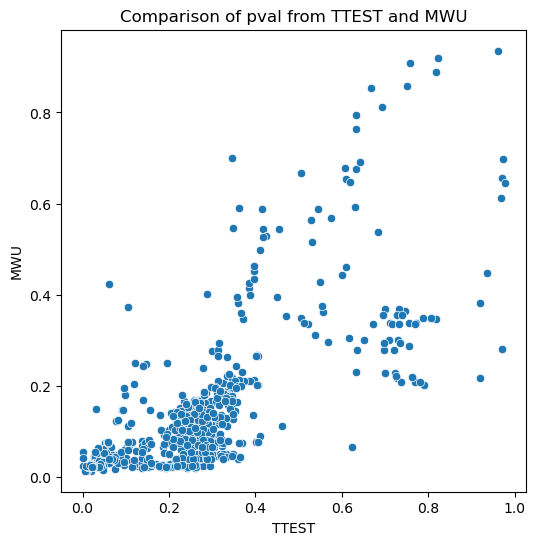

In [86]:
fig = plt.figure(figsize=(6,6))
ax1=fig.add_subplot(1,1,1)

sns.scatterplot(
    x=tmp1['pval'].values,
    y=tmp2['pval'].values,
    ax=ax1
)
ax1.set_xlabel("TTEST")
ax1.set_ylabel("MWU")

ax1.set_title("Comparison of pval from TTEST and MWU")

plt.show()

Text(0.5, 0.98, 'Candidate UP ivv ivt (clust 1, 8) vs all other promoters')

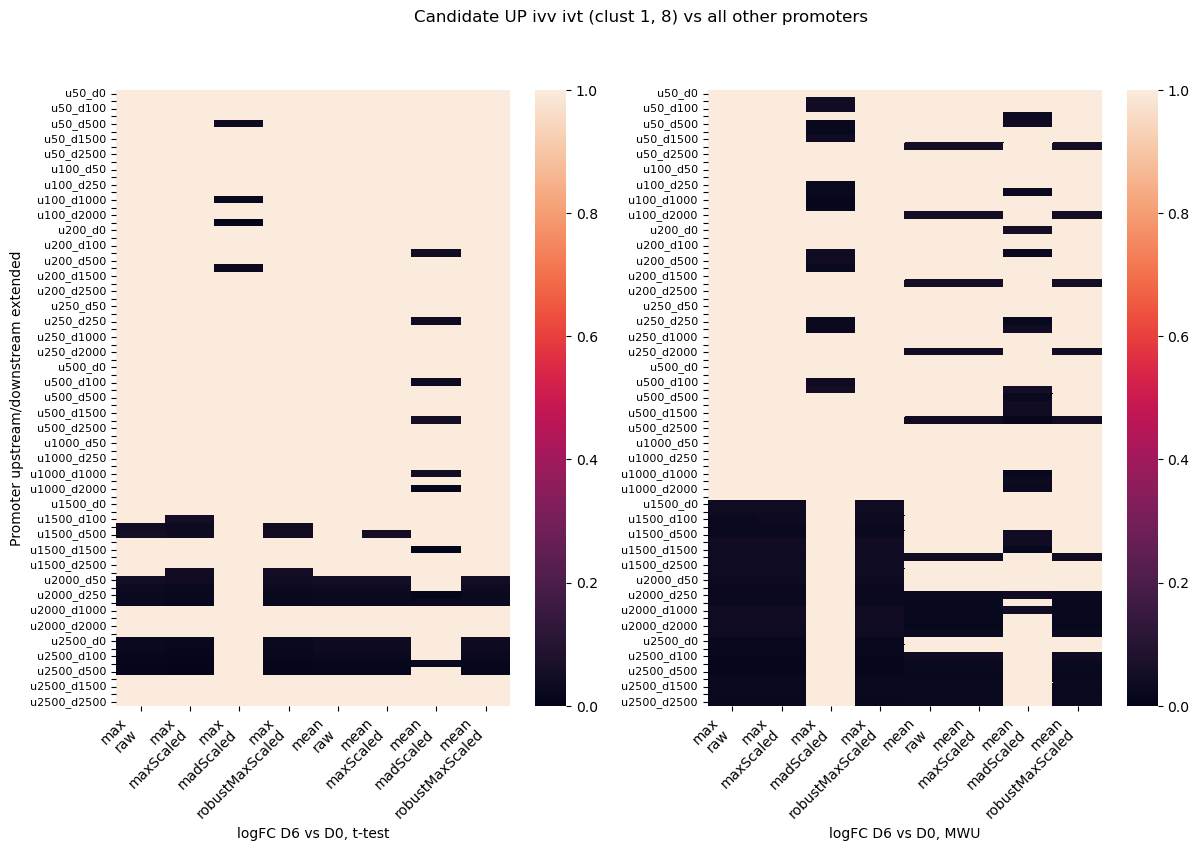

In [87]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


g = sns.heatmap(
    data=tmp1_p.applymap(lambda v: 1 if v>0.05 else v),
    vmin=0,
    vmax=1.0,
    xticklabels=True,
    yticklabels=True,
    ax=ax1
)

g = sns.heatmap(
    data=tmp2_p.applymap(lambda v: 1 if v>0.05 else v),
    vmin=0,
    vmax=1.0,
    xticklabels=True,
    yticklabels=True,
    ax=ax2
)

for ax in (ax1,ax2):
    ax.set_yticklabels(
        [t if i%2==0 else "" for i, t in enumerate(ax.get_yticklabels()) ],
        fontsize=8
    )
    ax.set_xticklabels(
        ["\n".join(t.get_text().split('_')[1:]) for t in ax.get_xticklabels()],
        rotation=45,
        ha='right',
    )

_ = ax1.set_ylabel("Promoter upstream/downstream extended")
_ = ax2.set_ylabel("")

_ = ax1.set_xlabel("logFC D6 vs D0, t-test\n")
_ = ax2.set_xlabel("logFC D6 vs D0, MWU\n")

plt.suptitle(TITLE)

### Candidate UP ivv ivt (clust 1, 8) vs other **measured miRNAs** promoters

In [46]:
data_full_tests_df['mirna_set'].unique()

array(['cand_IvvIvtUp_vs_all', 'cand_IvvIvtUp_vs_otherMeasured',
       'cand_IvtUp_vs_all', 'cand_IvtUp_vs_otherMeasured'], dtype=object)

In [88]:

TITLE = "Candidate UP ivv ivt (clust 1, 8) vs promoters from other measured miRNAs"
mirna_set = 'cand_IvvIvtUp_vs_otherMeasured'

tmp1 = data_full_tests_df.loc[
    lambda df: (
        (df['mirna_set']==mirna_set) &
        (df['test']=='TTEST')
    ),:]


tmp1_p = tmp1.pivot_table(
    index='prom_coords',
    columns='score_processing',
    values='pval'
)

tmp1_p = tmp1_p.loc[sorted_prom_index, sorted_score_cols]

tmp2 = data_full_tests_df.loc[
    lambda df: (
        (df['mirna_set']==mirna_set) &
        (df['test']=='MWU')
    ),:]


tmp2_p = tmp2.pivot_table(
    index='prom_coords',
    columns='score_processing',
    values='pval'
)

tmp2_p = tmp2_p.loc[sorted_prom_index, sorted_score_cols]


Text(0.5, 0.98, 'Candidate UP ivv ivt (clust 1, 8) vs promoters from other measured miRNAs')

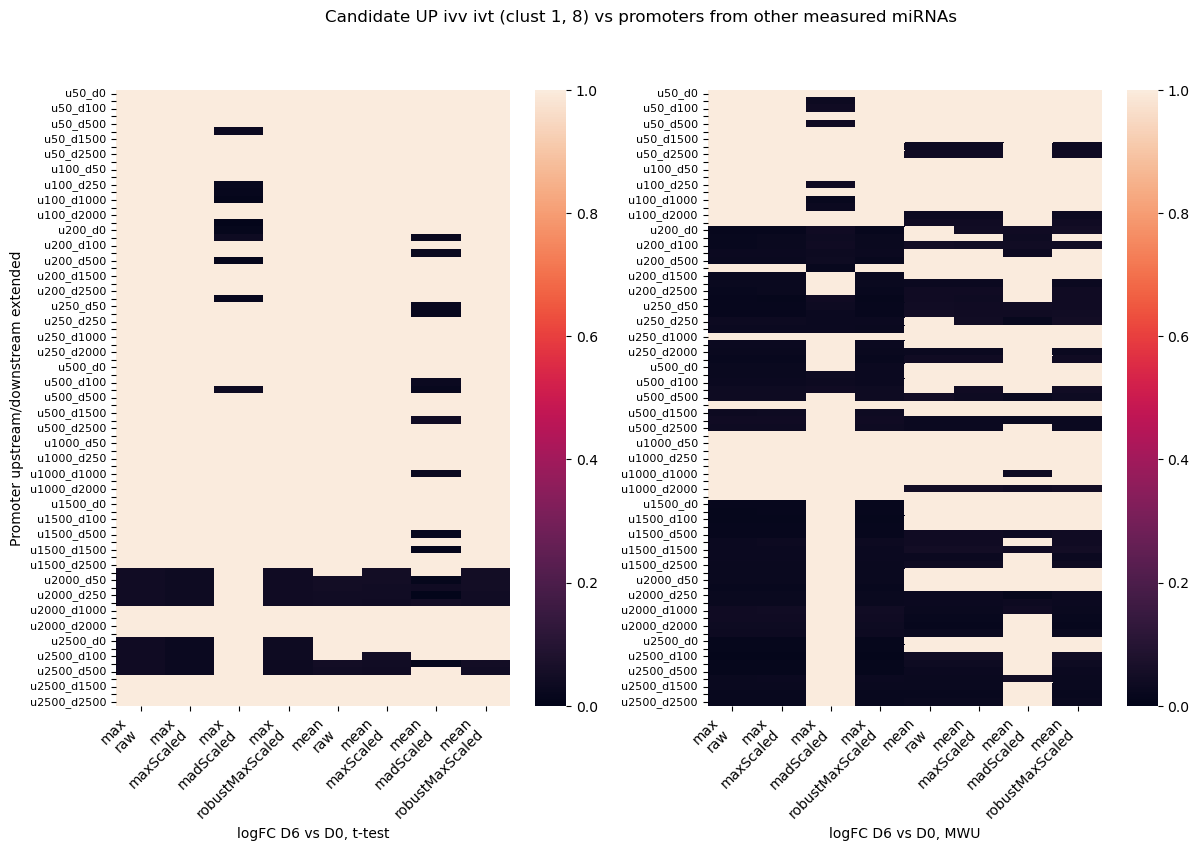

In [89]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

g = sns.heatmap(
    data=tmp1_p.applymap(lambda v: 1 if v>0.05 else v),
    vmin=0,
    vmax=1.0,
    xticklabels=True,
    yticklabels=True,
    ax=ax1
)

g = sns.heatmap(
    data=tmp2_p.applymap(lambda v: 1 if v>0.05 else v),
    vmin=0,
    vmax=1.0,
    xticklabels=True,
    yticklabels=True,
    ax=ax2
)

for ax in (ax1,ax2):
    ax.set_yticklabels(
        [t if i%2==0 else "" for i, t in enumerate(ax.get_yticklabels()) ],
        fontsize=8
    )
    ax.set_xticklabels(
        ["\n".join(t.get_text().split('_')[1:]) for t in ax.get_xticklabels()],
        rotation=45,
        ha='right',
    )

_ = ax1.set_ylabel("Promoter upstream/downstream extended")
_ = ax2.set_ylabel("")

_ = ax1.set_xlabel("logFC D6 vs D0, t-test\n")
_ = ax2.set_xlabel("logFC D6 vs D0, MWU\n")

plt.suptitle(TITLE)

### Candidate miRNAs UP ivt only vs all

In [253]:
TITLE = "Candidate UP ivt vs all other promoters"
mirna_set = 'cand_IvtUp_vs_all'

tmp1 = data_full_tests_df.loc[
    lambda df: (
        (df['mirna_set']==mirna_set) &
        (df['test']=='TTEST')
    ),:]


tmp1_p = tmp1.pivot_table(
    index='prom_coords',
    columns='score_processing',
    values='pval'
)

tmp1_p = tmp1_p.loc[sorted_prom_index, sorted_score_cols]

tmp2 = data_full_tests_df.loc[
    lambda df: (
        (df['mirna_set']==mirna_set) &
        (df['test']=='MWU')
    ),:]


tmp2_p = tmp2.pivot_table(
    index='prom_coords',
    columns='score_processing',
    values='pval'
)

tmp2_p = tmp2_p.loc[sorted_prom_index, sorted_score_cols]


Text(0.5, 0.98, 'Candidate UP ivt vs all other promoters')

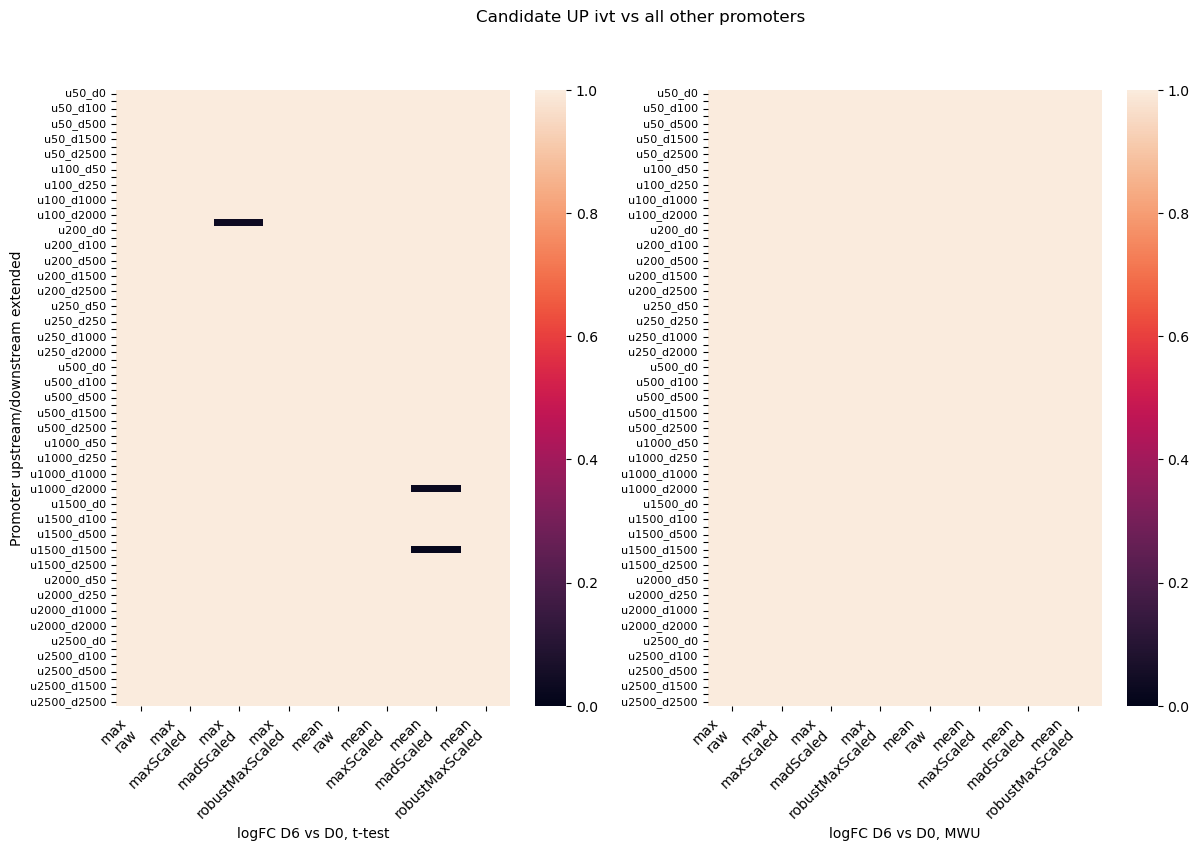

In [254]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

g = sns.heatmap(
    data=tmp1_p.applymap(lambda v: 1 if v>0.05 else v),
    vmin=0,
    vmax=1.0,
    xticklabels=True,
    yticklabels=True,
    ax=ax1
)

g = sns.heatmap(
    data=tmp2_p.applymap(lambda v: 1 if v>0.05 else v),
    vmin=0,
    vmax=1.0,
    xticklabels=True,
    yticklabels=True,
    ax=ax2
)

for ax in (ax1,ax2):
    ax.set_yticklabels(
        [t if i%2==0 else "" for i, t in enumerate(ax.get_yticklabels()) ],
        fontsize=8
    )
    ax.set_xticklabels(
        ["\n".join(t.get_text().split('_')[1:]) for t in ax.get_xticklabels()],
        rotation=45,
        ha='right',
    )

_ = ax1.set_ylabel("Promoter upstream/downstream extended")
_ = ax2.set_ylabel("")

_ = ax1.set_xlabel("logFC D6 vs D0, t-test\n")
_ = ax2.set_xlabel("logFC D6 vs D0, MWU\n")

plt.suptitle(TITLE)

### Candidate miRNA UP ivt vs other measured ivt

In [255]:
TITLE = "Candidate UP ivt vs other measured promoters"
mirna_set = 'cand_IvtUp_vs_otherMeasured'

tmp1 = data_full_tests_df.loc[
    lambda df: (
        (df['mirna_set']==mirna_set) &
        (df['test']=='TTEST')
    ),:]


tmp1_p = tmp1.pivot_table(
    index='prom_coords',
    columns='score_processing',
    values='pval'
)

tmp1_p = tmp1_p.loc[sorted_prom_index, sorted_score_cols]

tmp2 = data_full_tests_df.loc[
    lambda df: (
        (df['mirna_set']==mirna_set) &
        (df['test']=='MWU')
    ),:]


tmp2_p = tmp2.pivot_table(
    index='prom_coords',
    columns='score_processing',
    values='pval'
)

tmp2_p = tmp2_p.loc[sorted_prom_index, sorted_score_cols]


Text(0.5, 0.98, 'Candidate UP ivt vs other measured promoters')

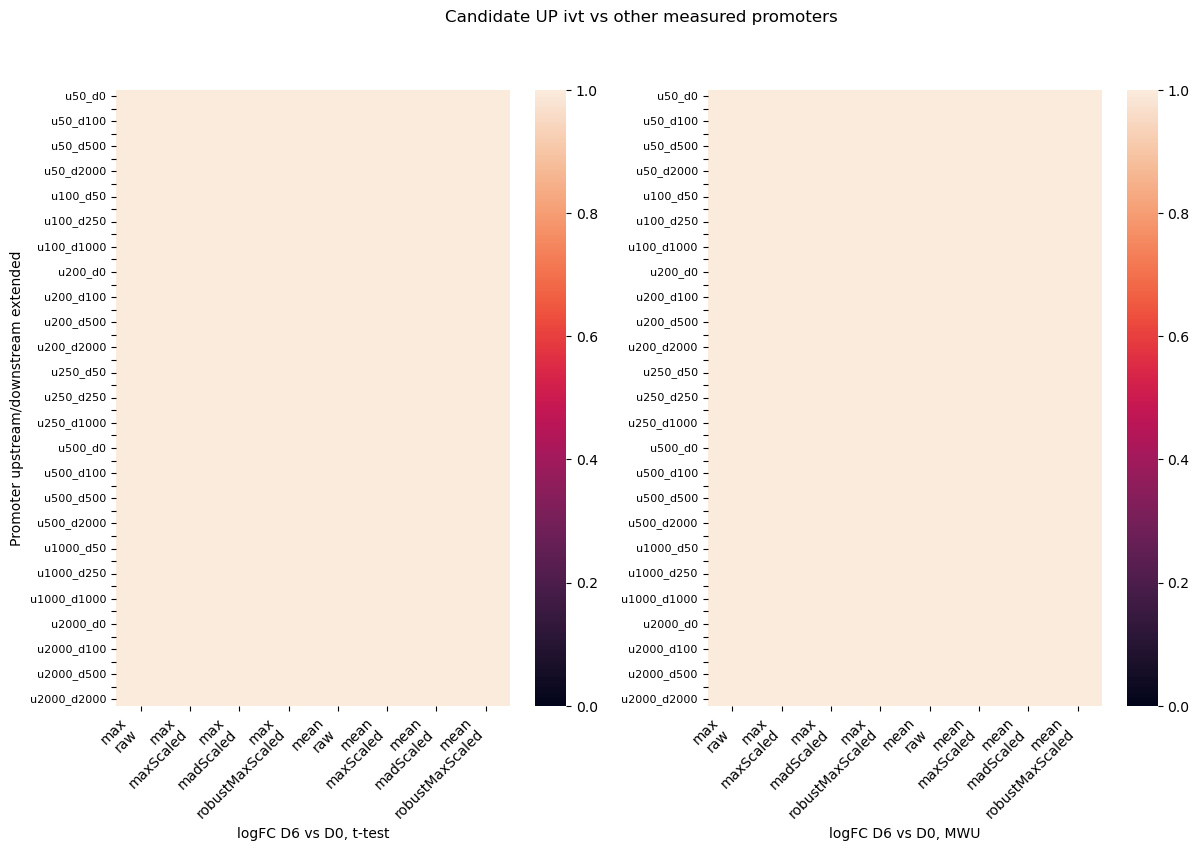

In [220]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

g = sns.heatmap(
    data=tmp1_p.applymap(lambda v: 1 if v>0.05 else v),
    vmin=0,
    vmax=1.0,
    xticklabels=True,
    yticklabels=True,
    ax=ax1
)

g = sns.heatmap(
    data=tmp2_p.applymap(lambda v: 1 if v>0.05 else v),
    vmin=0,
    vmax=1.0,
    xticklabels=True,
    yticklabels=True,
    ax=ax2
)

for ax in (ax1,ax2):
    ax.set_yticklabels(
        [t if i%2==0 else "" for i, t in enumerate(ax.get_yticklabels()) ],
        fontsize=8
    )
    ax.set_xticklabels(
        ["\n".join(t.get_text().split('_')[1:]) for t in ax.get_xticklabels()],
        rotation=45,
        ha='right',
    )

_ = ax1.set_ylabel("Promoter upstream/downstream extended")
_ = ax2.set_ylabel("")

_ = ax1.set_xlabel("logFC D6 vs D0, t-test\n")
_ = ax2.set_xlabel("logFC D6 vs D0, MWU\n")

plt.suptitle(TITLE)